# Classifying Pulsar Candidates Using a K-NN Algorithm

## Introduction
- Pulsars are rotating neutron stars observed to have pulses of radiation at very regular intervals, typically ranging from milliseconds to seconds. These accelerated particles produce very powerful beams of light, with some pulsars producing enough radio emissions to be detected on earth (Ng et al., 2015).
- Since their initial discovery in 1967, Pulsars have been matters of great scientific interest, due to their    nature as gravitational probes and inter-stellar media (Eatough et al., 2010). 
- Detection of Pulsars is a complex task, and involves the discerening of fleeting Pulsar signals from a copious amount of background radio frequency interference (Eatough et al., 2010). To aid in the detection of Pulsars, computer algorithms can speed up the process and accuracy. Within our project, we aim to create a supervised *K*-Nearest Neighbors algorithm in the binary classification of Pulsar star state.


**Predictive question:** Can we create a *K*-nearest neighbor algorithm capable of classifying whether an observation is a Pulsar star or not, given the observation's integrated profile, skewness profile, mean of DM-SNR curve, excess kurtosis of DM-SNR curve and the skewness of DM-SNR curve?


#### Dataset
- The data set that we use describes a sample of pulsar candidates collected as part of the High Time Resolution Universe Survey of the southern hemisphere.
- The data set contains a total of 8 different features and 1 class variable. Much of the variables are in relation to the dispersion measure-signal-to-noise ratio (DM-SNR) of each recorded observation. 

## Exploratory data analysis

In [1]:
# Importing libraries and setting seed
library(tidyverse)
library(tidymodels)

set.seed(100)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Reading and wrangling the data from internet:

In [11]:
# Since the initial data file is in a zip folder, we created a new repository on github, and 
# utilized the raw link to demonstrate that the data can be read from the web

pulsar_df <- read_csv("https://raw.githubusercontent.com/MichaelZhang33/HTRU2.csv/main/HTRU_2.arff", 
                      skip = 11, col_names = FALSE) |>
    rename("Profile_mean" = X1,
       "Profile_stdev" = X2,
       "Profile_skewness" = X3,
       "Profile_kurtosis" = X4,
       "DM_mean" = X5, 
       "DM_stdev" = X6, 
       "DM_skewness" = X7,
       "DM_kurtosis" = X8,
       "class" = X9) |>
# Further wrangling and cleaning the data
    mutate(class = as_factor(class)) |>
    mutate(Class = fct_recode(class, "notpulsar" = "0", "pulsar" = "1")) |>
    select(-Profile_mean, -Profile_stdev, -DM_stdev, -class)

head(pulsar_df)
 

# Splitting the dataset into a training and testing set
pulsar_split <- initial_split(pulsar_df, prop = 0.75, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Profile_skewness,Profile_kurtosis,DM_mean,DM_skewness,DM_kurtosis,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.23457141,-0.6996484,3.199833,7.975532,74.24222,notpulsar
0.46531815,-0.5150879,1.677258,10.576487,127.39358,notpulsar
0.32332837,1.0511644,3.121237,7.735822,63.17191,notpulsar
-0.06841464,-0.6362384,3.642977,6.896499,53.59366,notpulsar
0.60086608,1.1234917,1.178930,14.269573,252.56731,notpulsar
0.53190485,0.4167211,1.636288,10.621748,131.39400,notpulsar


### Exploratory data analysis

##### 1. Summary table for the number of pulsar star observations and non-pulsar star observations in the training set:

In [12]:
useful_df_1 <- pulsar_train |>
    group_by(Class) |>
    summarize(count = n())
useful_df_1

# These results indicate that the dataset is not balanced, and will require oversampling of the positive pulsar cases.

Class,count
<fct>,<int>
notpulsar,12199
pulsar,1224


##### 2. Summary table for the average value of each predictor variable based on class:

In [4]:
useful_df_2 <- pulsar_train |>
    group_by(Class) |>
    summarize(mean_profile_skewness = mean(Profile_skewness), 
              mean_profile_kurtosis = mean(Profile_kurtosis), 
              mean_DM_mean = mean(DM_mean), 
              mean_DM_skewness = mean(DM_skewness), 
              mean_DM_kurtosis = mean(DM_kurtosis))
useful_df_2

Class,mean_profile_skewness,mean_profile_kurtosis,mean_DM_mean,mean_DM_skewness,mean_DM_kurtosis
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
notpulsar,0.2118807,0.385433,8.712282,8.899551,114.5603
pulsar,3.1267329,15.464049,51.287674,2.723142,18.1926


##### 3. Number of rows in each column that have na values:

In [5]:
useful_df_3 <- colSums(is.na(pulsar_train))
useful_df_3

Profile_skewness Profile_kurtosis          DM_mean      DM_skewness 
               0                0                0                0 
     DM_kurtosis            Class 
               0                0

### Useful visualisations

#### 1. Distribution of Profile_skewness

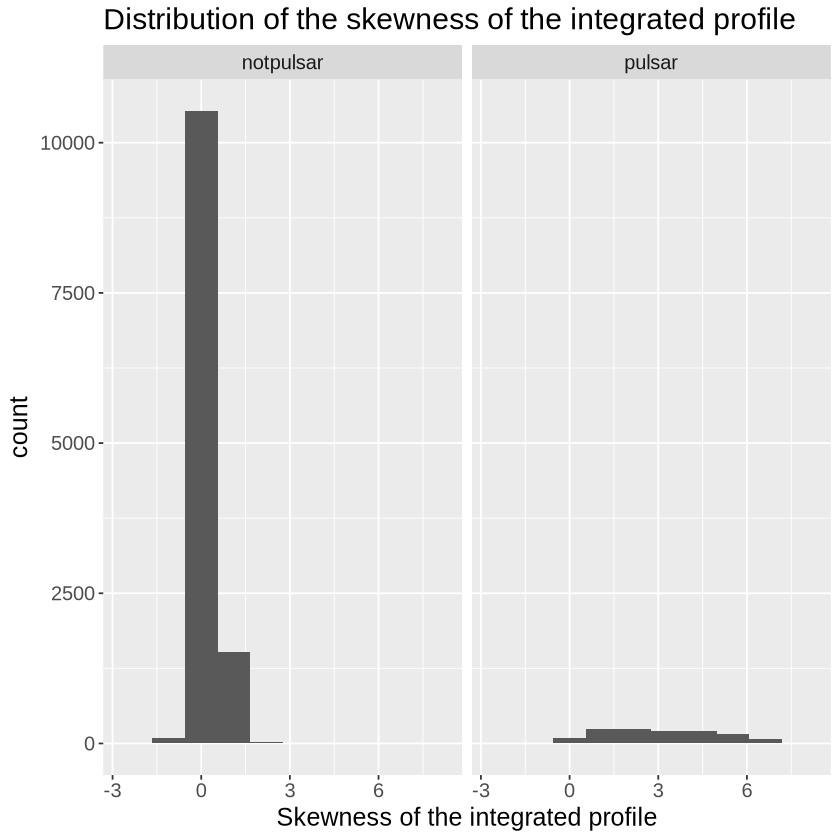

In [6]:
profile_sk_distribution <- pulsar_train |>
    select(Profile_skewness, Class) |>
    ggplot(aes(x = Profile_skewness)) +
    geom_histogram(bins = 10) +
    labs(x= "Skewness of the integrated profile") +
    ggtitle("Distribution of the skewness of the integrated profile") +
    theme(text = element_text(size = 15)) +
    facet_grid(cols = vars(Class))
profile_sk_distribution

#### 2. Distribution of Profile_kurtosis

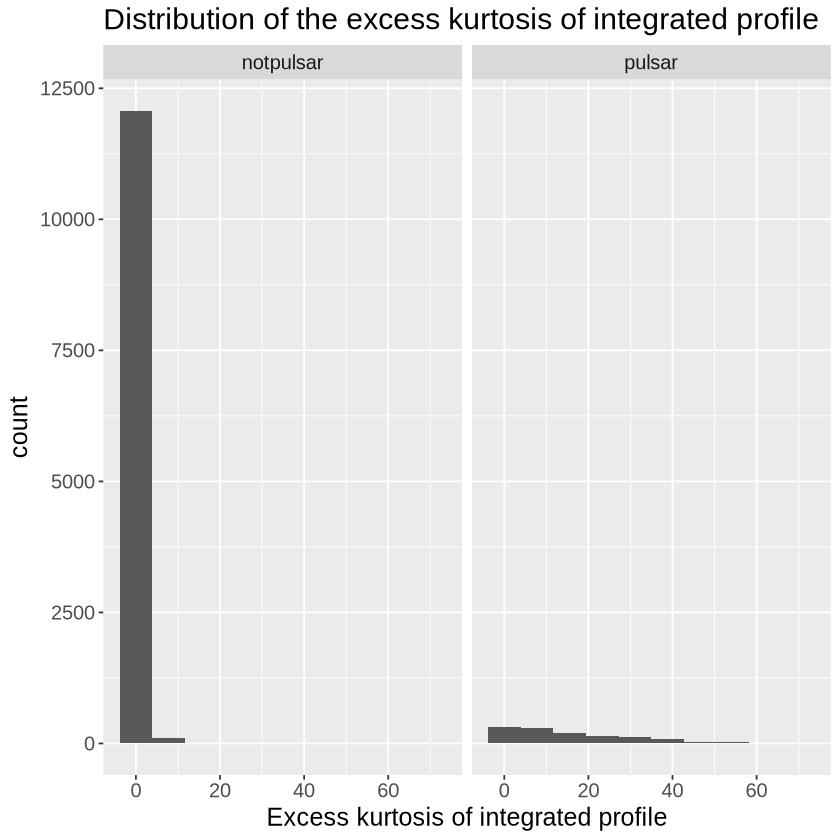

In [7]:
profile_kur_distribution <- pulsar_train |>
    select(Profile_kurtosis, Class) |>
    ggplot(aes(x = Profile_kurtosis)) +
    geom_histogram(bins = 10) +
    labs(x= "Excess kurtosis of integrated profile") +
    ggtitle("Distribution of the excess kurtosis of integrated profile") +
    theme(text = element_text(size = 15)) +
    facet_grid(cols = vars(Class))
profile_kur_distribution

#### 3. Distribution of DM_mean

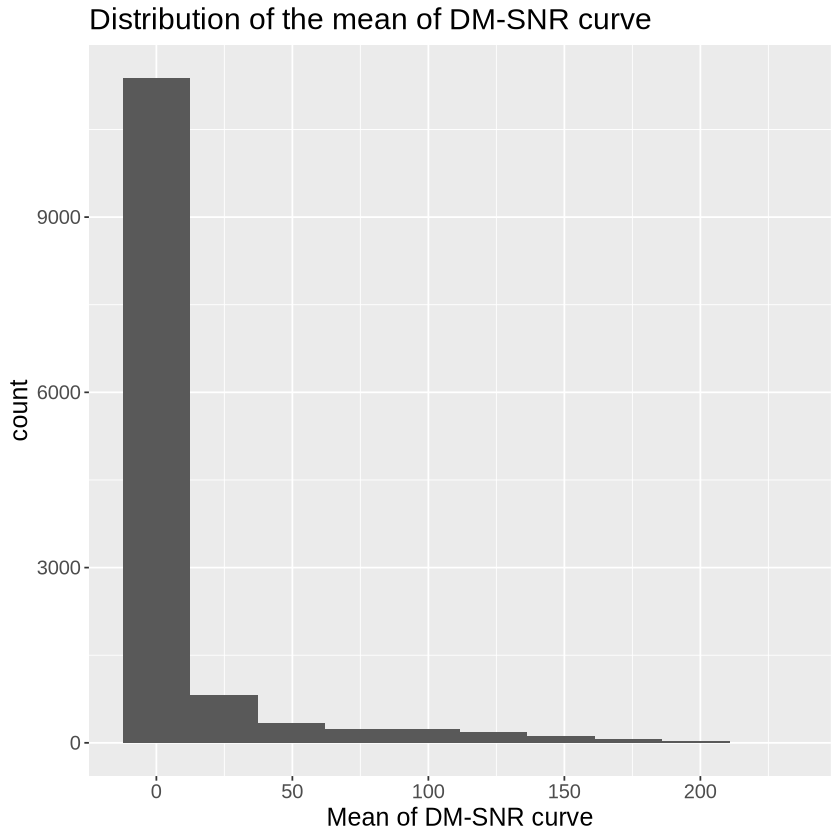

In [8]:
profile_dmMean_distribution <- pulsar_train |>
    select(DM_mean) |>
    ggplot(aes(x = DM_mean)) +
    geom_histogram(bins = 10) +
    labs(x= "Mean of DM-SNR curve") +
    ggtitle("Distribution of the mean of DM-SNR curve") +
    theme(text = element_text(size = 15))
profile_dmMean_distribution

#### 4. Distribution of DM_skewness

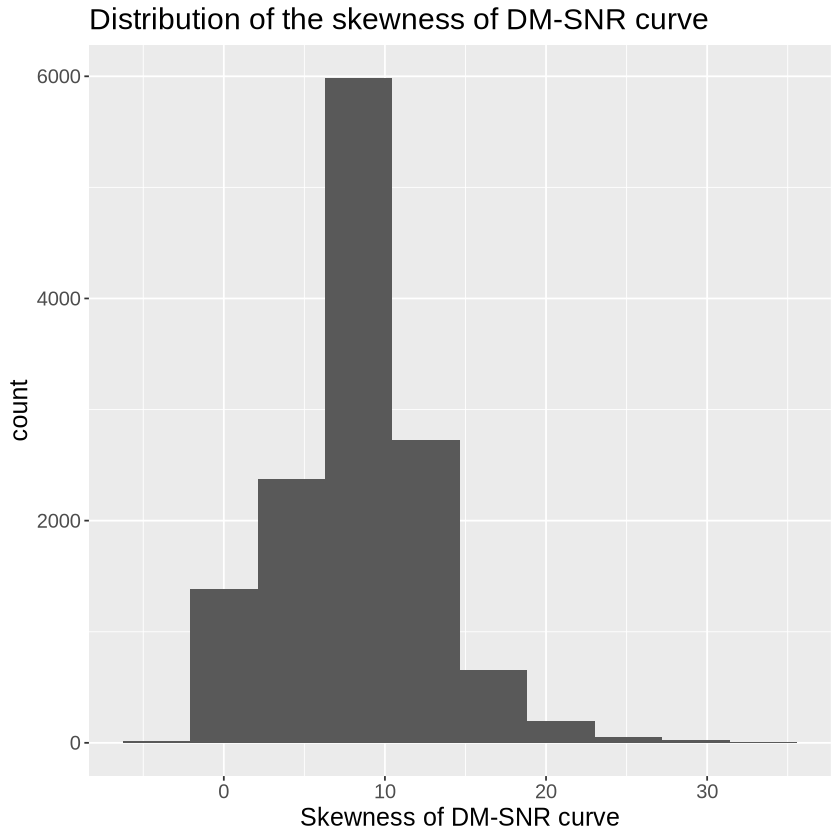

In [9]:
profile_dmsk_distribution <- pulsar_train |>
    select(DM_skewness) |>
    ggplot(aes(x = DM_skewness)) +
    geom_histogram(bins = 10) +
    labs(x= "Skewness of DM-SNR curve") +
    ggtitle("Distribution of the skewness of DM-SNR curve") +
    theme(text = element_text(size = 15))
profile_dmsk_distribution

#### 5. Distribution of DM_kurtosis

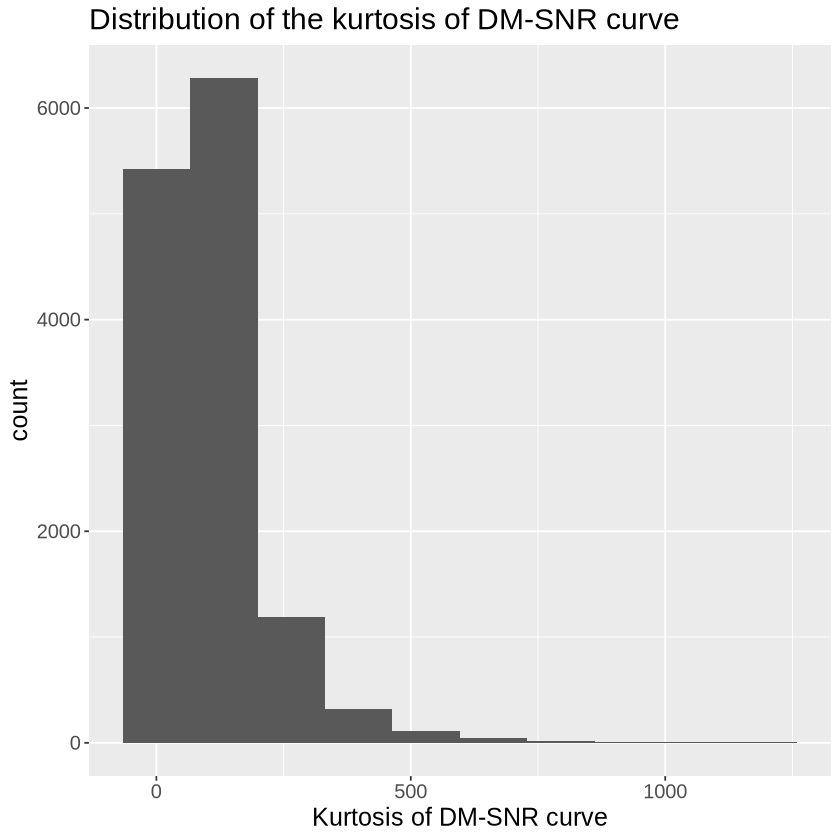

In [10]:
profile_dmKur_distribution <- pulsar_train |>
    select(DM_kurtosis) |>
    ggplot(aes(x = DM_kurtosis)) +
    geom_histogram(bins = 10) +
    labs(x= "Kurtosis of DM-SNR curve") +
    ggtitle("Distribution of the kurtosis of DM-SNR curve") +
    theme(text = element_text(size = 15))
profile_dmKur_distribution

## Methods
To answer our question, we will utilize some of the columns from the initial dataset. These include:
 
1. The excess kurtosis of the integrated profile (*Profile_kurtosis*)
2. The skewness of the integrated profile (*Profile_skewness*)
3. Mean of the DM-SNR curve (*DM_mean*)
4. Excess kurtosis of the DM-SNR curve (*DM_kurtosis*)
5. Skewness of the DM-SNR curve (*DM_skewness*)
6. Whether the star is a pulsar or not

Using the first 5 columns, we will predict through *classification* to determing whether the observation is a pulsar star or not. 

**Visualisation:** We will visualize our results by creating different 

## Expected outcomes and significance

**What we expect to find**
- We expect that our model will predict the pulsars with fair accuracy
- We expect lower mean integrated profile would equal a more intense beam of light, and hence would indicate a pulsar star
-  the DM-SNR curve measures the variance of the SNR of a pulsar star; a pulsar star would indicate a higher value for the DM-SNR curve, as those stars have a stronger signal. Hence, higher mean of DM-SNR curve should indicate a pulsar star

**Impacts of our finding**
- This data analysis can help scientists classify whether the stars are pulsars or not, because Pulsars are of considerable scientific interest, because of their interesting properties

**Future questions this data analysis could lead to:** 
- Are there any other factors that can help in determining whether the star is a pulsar?
- Are there some factors that doesn't help in determining whether the star is a pulsar?

#### <center> References </center>
Eatough, R. P., Molkenthin, N., Kramer, M., Noutsos, A., Keith, M. J., Stappers, B. W., & Lyne, A. G. (2010). Selection of radio pulsar candidates using artificial neural networks. Monthly Notices of the Royal Astronomical Society, 407(4), 2443–2450. https://doi.org/10.1111/j.1365-2966.2010.17082.x


Ng, C., Champion, D. J., Bailes, M., Barr, E. D., Bates, S. D., Bhat, N. D. R., Burgay, M., Burke-Spolaor, S., Flynn, C. M. L., Jameson, A., Johnston, S., Keith, M. J., Kramer, M., Levin, L., Petroff, E., Possenti, A., Stappers, B. W., van Straten, W., Tiburzi, C., & Eatough, R. P. (2015). The High Time Resolution Universe Pulsar Survey – XII. Galactic plane acceleration search and the discovery of 60 pulsars. Monthly Notices of the Royal Astronomical Society, 450(3), 2922–2947. https://doi.org/10.1093/mnras/stv753

